# Assignment 6.12 - Womanium Final Assignment
Author: Giuliana Siddi Moreau

Follow the example from [bootcamp 4](https://www.youtube.com/watch?v=kHJLwfDUSWI&list=PL_wGNAk5B0pXq98BJBKsbNH2Qjp1lk8dG&index=32) for creating the quantum walk operator for the case of a circle with 4 nodes, and design the quantum walk operator for the case of a line with 16 nodes:

A. Create a well-detailed Python Jupyter notebook that explains your algorithm, including the code parts covered in class, and pictures/figures where relevant.

Utilize the Python code from class: [quantum_walk_circle_example.py](). It can be found directly also in the Classiq Git Library in the community/womanium/assignments folder.
Feel free to extend the example beyond the requirements here and what was covered in class.


B. Contribute your notebook to the Classiq Git Library. to the folder community/womanium/assignments

Follow the contribution guidelinese.  in order to contribute - NO need to open an issue for this, you can directly open a PR
The PR title should be: Womanium Final Assignment - \<First Name\> \<Last Name\>
The file name should be in the following format: \<first_name\>\_\<last_name\>_hw4.ipynb

A discrete-time quantum walk is a quantum analog of classical random walks. Unlike classical random walks, where the walker occupies definite states and randomness arises from stochastic transitions between states, discrete-time quantum walks exhibit unique features due to quantum interference. Here are some key points:

In discrete-time quantum walks, randomness arises through quantum superposition of states. The walker can be in a combination of different positions simultaneously. The evolution of a quantum walk is governed by a non-random, reversible unitary operator. This operator determines how the walker transitions between states. Measurement collapses the quantum state to a specific position, introducing randomness. The probability distribution of the walker’s position evolves over discrete time steps.

To define a quantum analog of this process, we need to specify a unitary operator U that controls the evolution of the position

This unitary is a combination of two steps: the Coin that decides in probability where the walker goes and the Swap that 


The graph on which we are supposed to do the quantum walk is a line formed by 16 vertices numbered from 0 to 15.
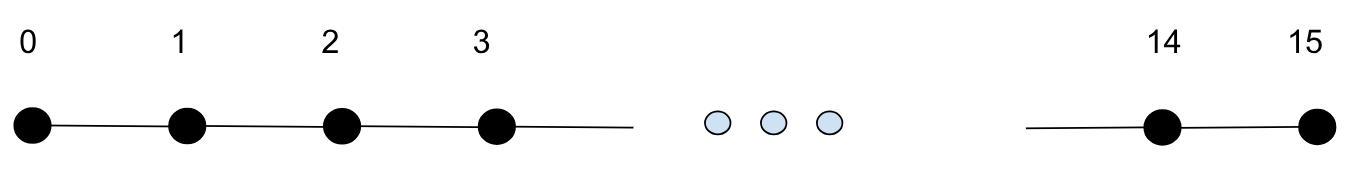

As the number of vertices is 16, $N=16$ and we need to encode on $n=log2(N)$ qubits. So the size parameter is equal to the number of qubits that encode the vertices and size=4

In [1]:
from classiq import *
import numpy as np

size = 4

Now we have to prepare the coin operator. The coin operator is encoded in the W step as a Grover operator that uses an additional ancilla that is set to the minus state in order to mark the vertex we are considering. Below we have the code snippet that prepares the state of the ancilla.

In [2]:
@qfunc
def prepare_minus(x: QBit):
  X(x)
  H(x)

In [3]:
@qfunc
def diffuzer_oracle(aux: Output[QNum],x:QNum):
  aux^=(x!=0)

In [4]:
@qfunc
def zero_diffuzer(x: QNum):
  aux = QNum('aux')
  allocate(1,aux)
  within_apply(compute=lambda: prepare_minus(aux),
              action=lambda: diffuzer_oracle)

First we need to encode the probabilities for each walker to transition to the other states at the beginning of the W iteration. The amplitudes are obviously the square root of the probabilities but we can use the __inplace_prepare_state__ method to assign the probabilities without computing the amplitudes.

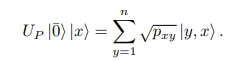

In the example we got as a reference, the topology of the graph was a circle, for four qubits we had the W_iteration that was written in a cyclic way to express continuity between the first node and the last node. So the probabilities governing the steps of the walker are 1/2 to go back and 1/2 to go forth, at every vertex of the graph


In [5]:
#this is the iteration for circles
def W_iteration_circle(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = [0]*(2**size)
    prob[(i+1)% (2**size)]=0.5
    prob[(i-1)% (2**size)]=0.5
    print(f'State={i}, prob vec ={prob}')

    control(ctrl=vertices==i,
            operand=lambda: within_apply(
              compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
              action= lambda: zero_diffuzer(adjacent_vertices)))

In the Quantum walk on a line graph we have to deal with the boundary condition at the beginning and at the end of the line, as when the walker finds itself at the edge of the line in both sides, it must go back with probability 1. 

In [6]:
#this is the iteration for lines
def W_iteration_line(i:int,vertices: QNum, adjacent_vertices:QNum):
    prob = np.zeros((2**(size))).tolist()
    if i == 0:
        prob[(i+1)] =1
    elif i == ((2**size)-1):
        prob[(i-1)] =1
    else:
        prob[(i+1)]=0.5
        prob[(i-1)]=0.5
    print(f'State={i}, prob vec ={prob}')
   
    
    control(ctrl=vertices==i,
            operand=lambda: within_apply(
                  compute= lambda: inplace_prepare_state(probabilities=prob, bound=0.01, target=adjacent_vertices),
                  action= lambda: zero_diffuzer(adjacent_vertices)))

So of course, as we are implementing a quantum walk on a line, we will use the above __W_iteration_line__ method. We need to apply the W operator to all the vertices, so we loop on the vertices from 0 to 15

In [7]:
@qfunc 
def W_operator(vertices:QNum, adjacent_vertices: QNum):
    for i in range(2**size):
      W_iteration_line(i,vertices,adjacent_vertices)

Then we need a code snippet that checks on the adjacent vertices 

In [8]:
@qfunc
def edge_oracle(res:Output[QBit], vertices: QNum, adjacent_vertices: QNum):
  res |= (((vertices+adjacent_vertices)%2) ==1)

Here we do the bitwise swap

In [9]:
@qfunc 
def bitwise_swap(x: QArray[QBit], y:QArray[QBit]):
  repeat(count= x.len,
    iteration= lambda i: SWAP(x[i],y[i]))
  

and this is the swap operator that check what are the adjacent vertices and swap the vertices

In [10]:
@qfunc 
def S_operator(vertices:QNum, adjacent_vertices: QNum):
    res = QNum('res')
    edge_oracle(res,vertices,adjacent_vertices)
    control(ctrl= res==1,
        operand= lambda: bitwise_swap(vertices,adjacent_vertices))

So here is the algorithm: we allocate the 4 qubits for the 16 vertices, we apply a hadamard transform to get an equal superposition for all the vertices.
Then we allocate four qubits for the adjacent vertices. We apply the W operator to initialize the walker with the probabilities of the given graph topology and we apply the Grover diffusion operator that corresponds to the coin flip.
Inside the S_operator check with the edge oracle what vertices are adjacent and we apply the swap operator 

In [13]:
@qfunc 
def main(vertices:Output[QNum], adjacent_vertices:Output[QNum]):
  allocate(size,vertices)
  hadamard_transform(vertices)
  allocate(size,adjacent_vertices)

  W_operator(vertices,adjacent_vertices)
  S_operator(vertices,adjacent_vertices)

Now let's create the model and synthesize it

In [15]:
  

qmod = create_model(main)
qprog = synthesize(qmod)
show(qprog)

State=0, prob vec =[0.0, 1, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=1, prob vec =[0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=2, prob vec =[0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=3, prob vec =[0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=4, prob vec =[0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=5, prob vec =[0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=6, prob vec =[0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=7, prob vec =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=8, prob vec =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0]
State=9, prob vec =[0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.5, 0.0, 0.5, 0.0, 0.0, 0.0, 0.0, 0.0]
St

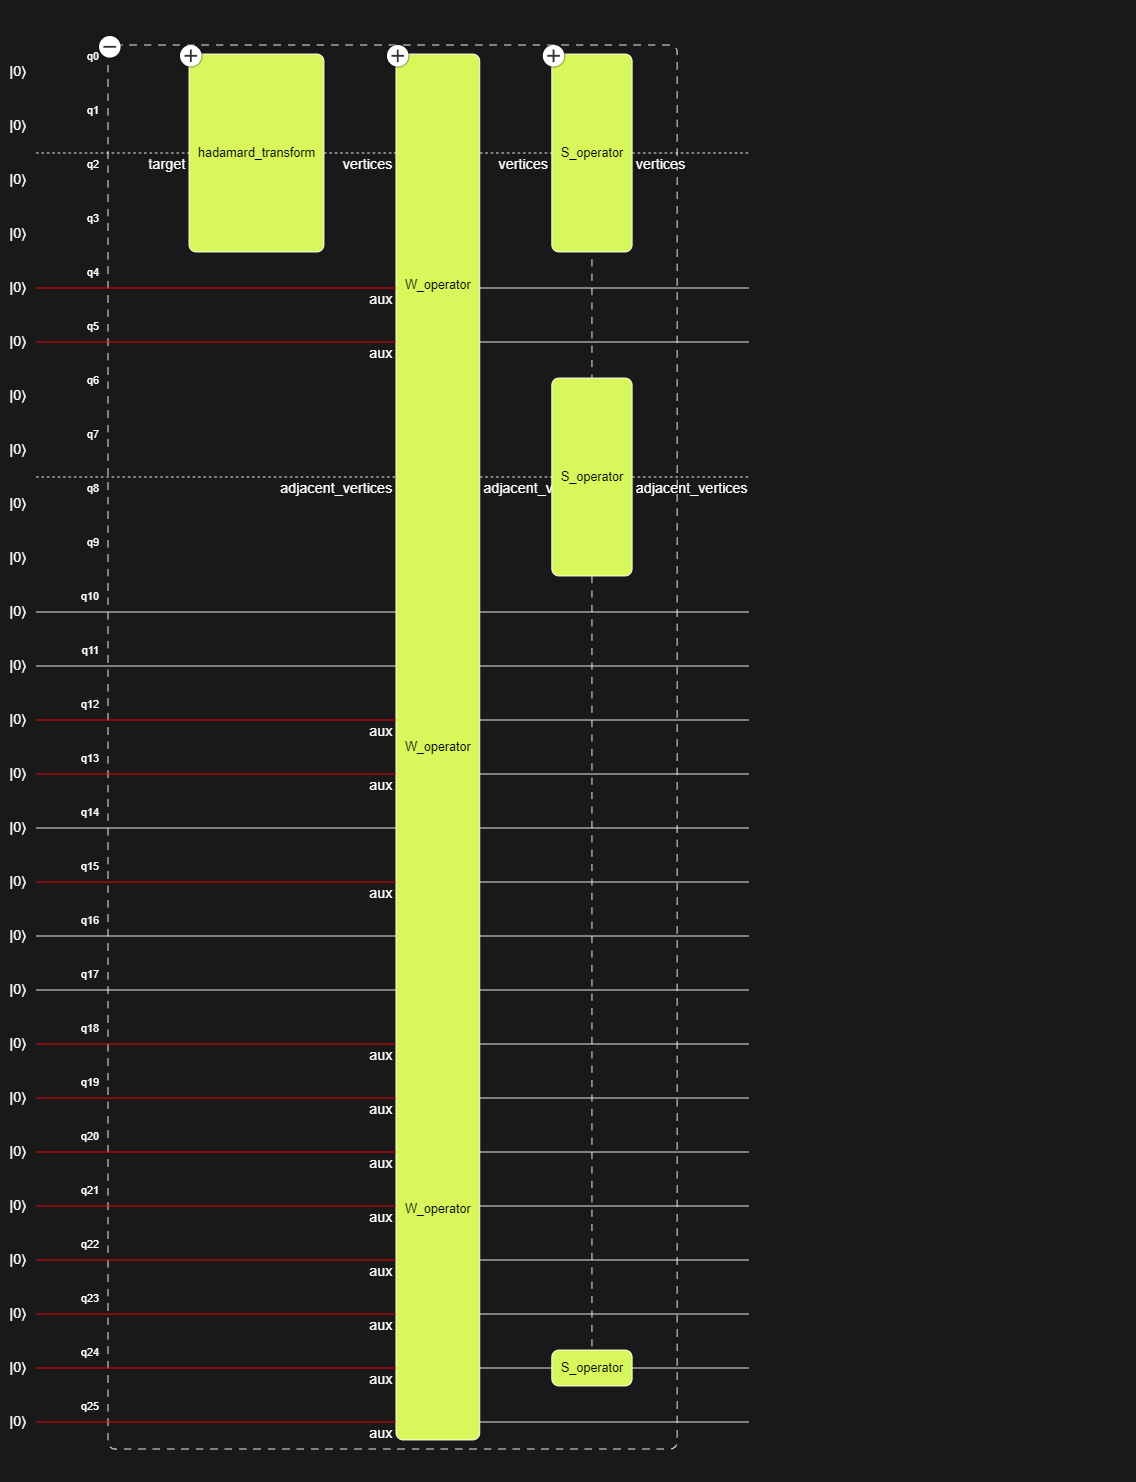

If we look at the transpiled circuit, it is quite large (26 qubits)

### Circuit Parameters
Depth: 2511

Width: 26


### Gate count

U : 2181

CX : 2057



As all simulator have 25 qubits available so it's impossible to run it on a simulator (by the way before the Simulator MPS got 30 qubits available, but the aim of the exercise is to use the constraints we learnt in order to fit on 25 qubits.
Let's syntesize the quantum modelwith a constraint minimizing width

In [16]:
qmod2 = set_constraints(qmod, Constraints(optimization_parameter="width", max_depth=5000))

In [17]:
qprog2 = synthesize(qmod2)
show(qprog2)

Opening: https://platform.classiq.io/circuit/9db7341d-ecd9-4196-83e9-c6b3c540e2e4?version=0.43.3


We got this circuit on 25 qubits
### Circuit Parameters

Depth: 2317

Width: 25

### Gate count

U : 2513
CX : 2393

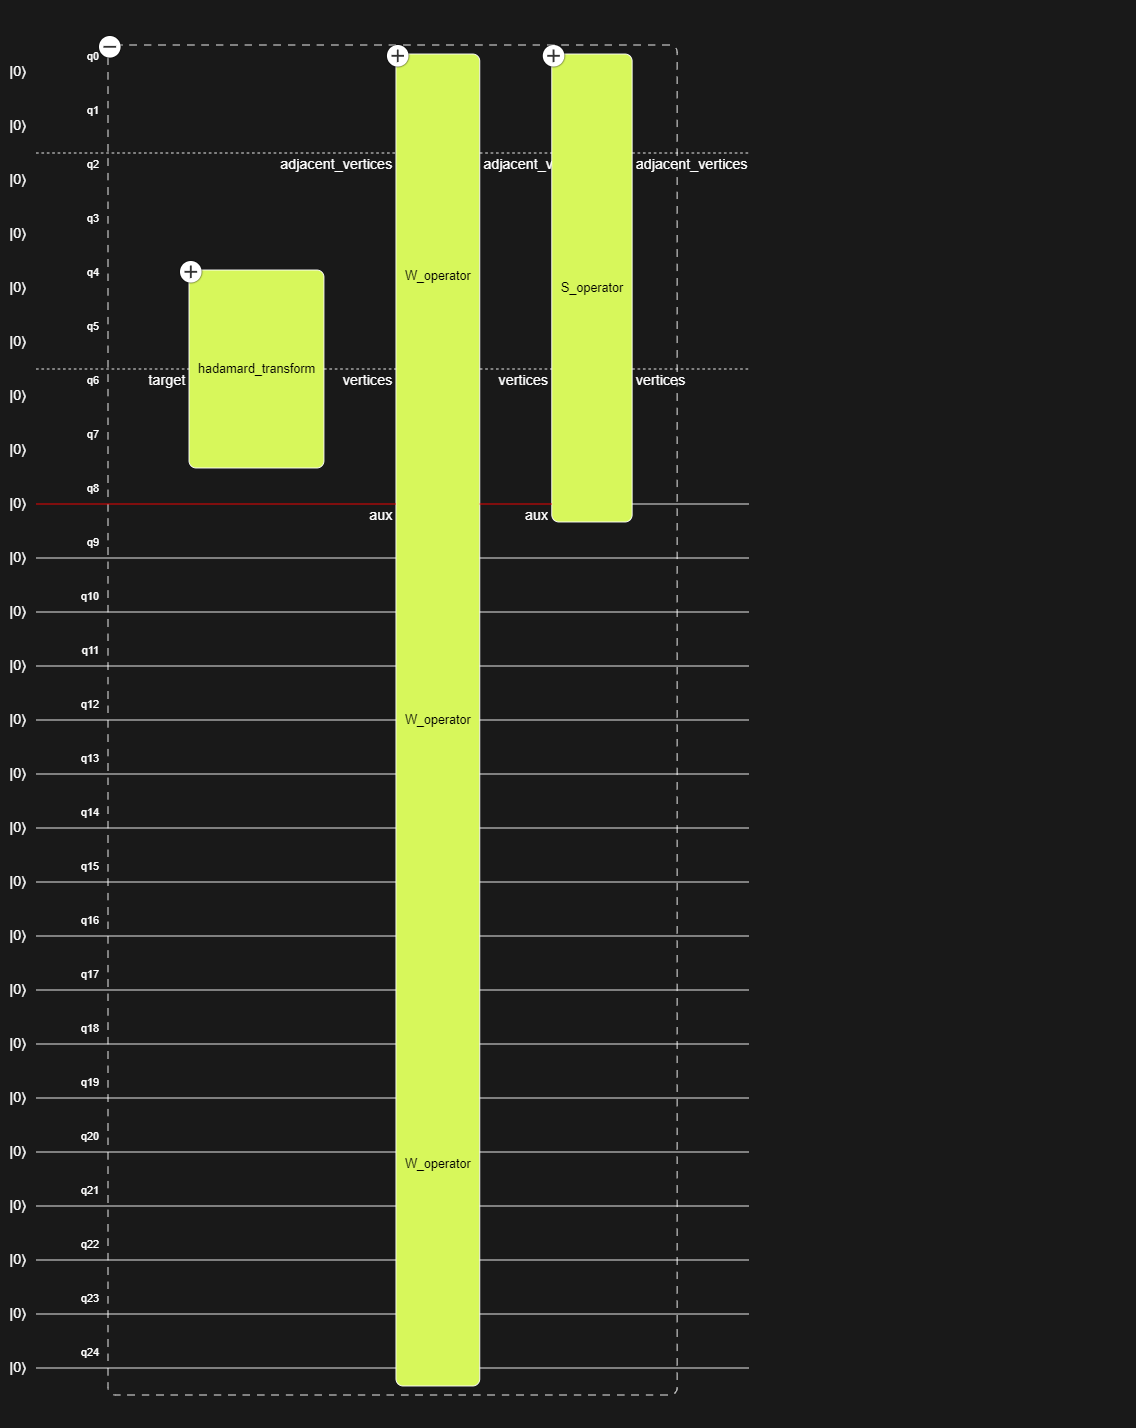

Let's delve into the circuit structure. In the first block we have the Hadamard wall on vertices in order to put the qubits that encode vertices in a state of maximum superposition
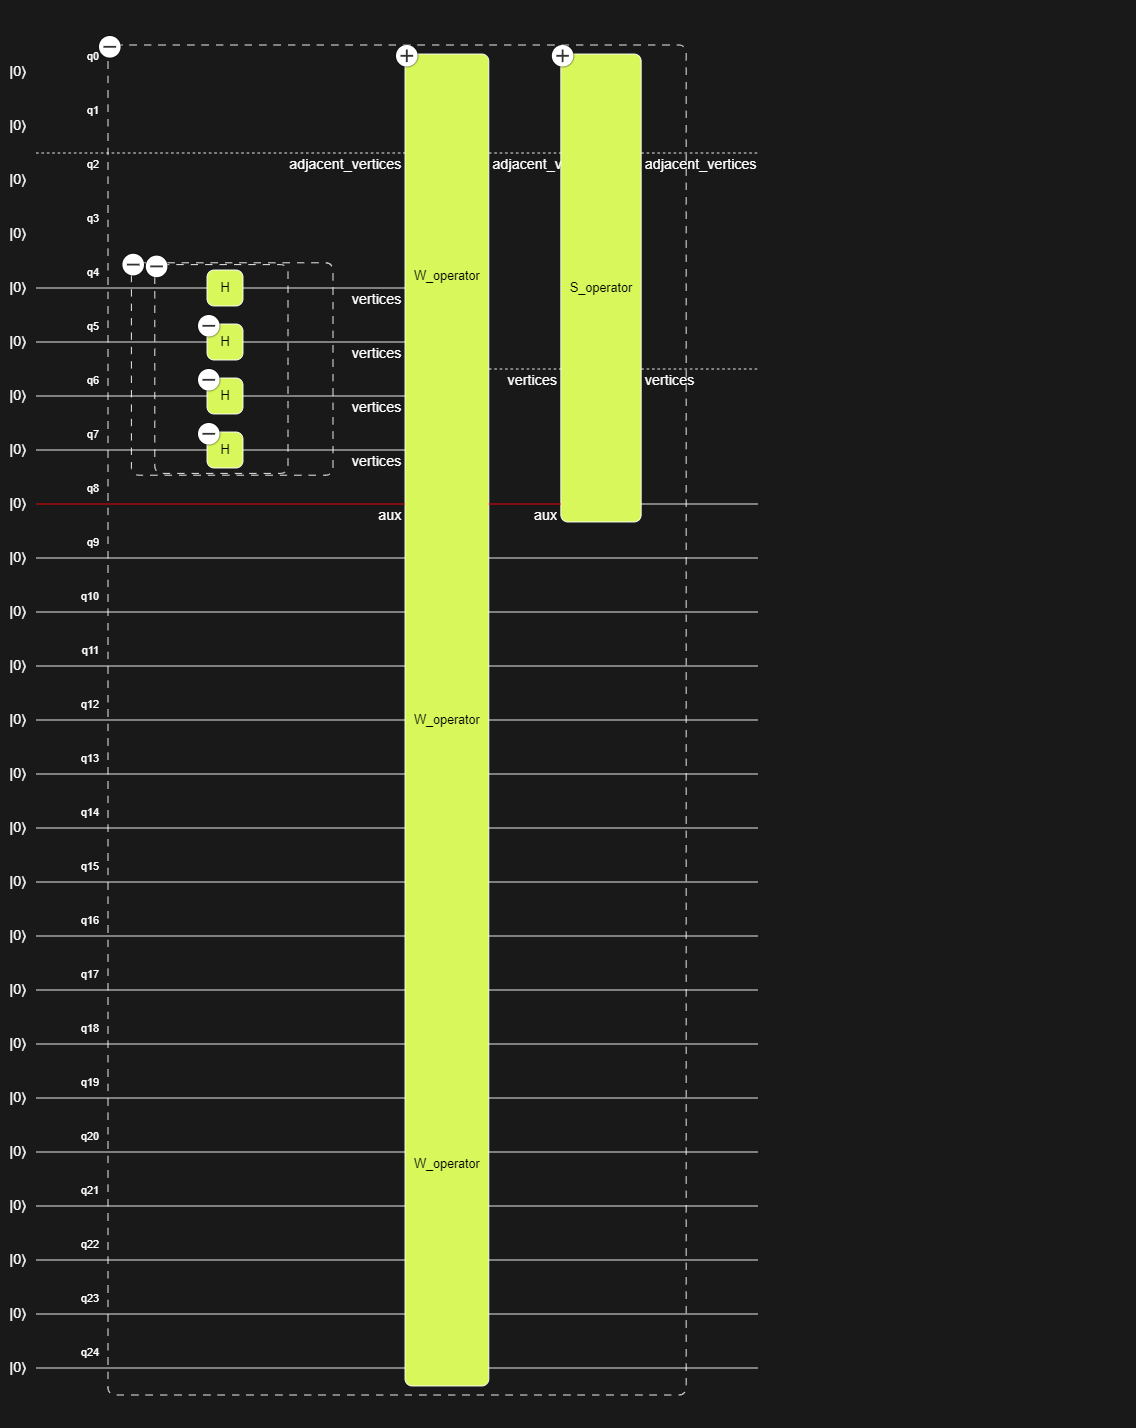




The W operator contains 16 diffuser blocks, each acting as a coin operator on a given vertex of the graph,  that are bracketed by state preparation operation that set the probabilities for the walker according to the given graph topology and  the corresponding inverse state preparation operation 

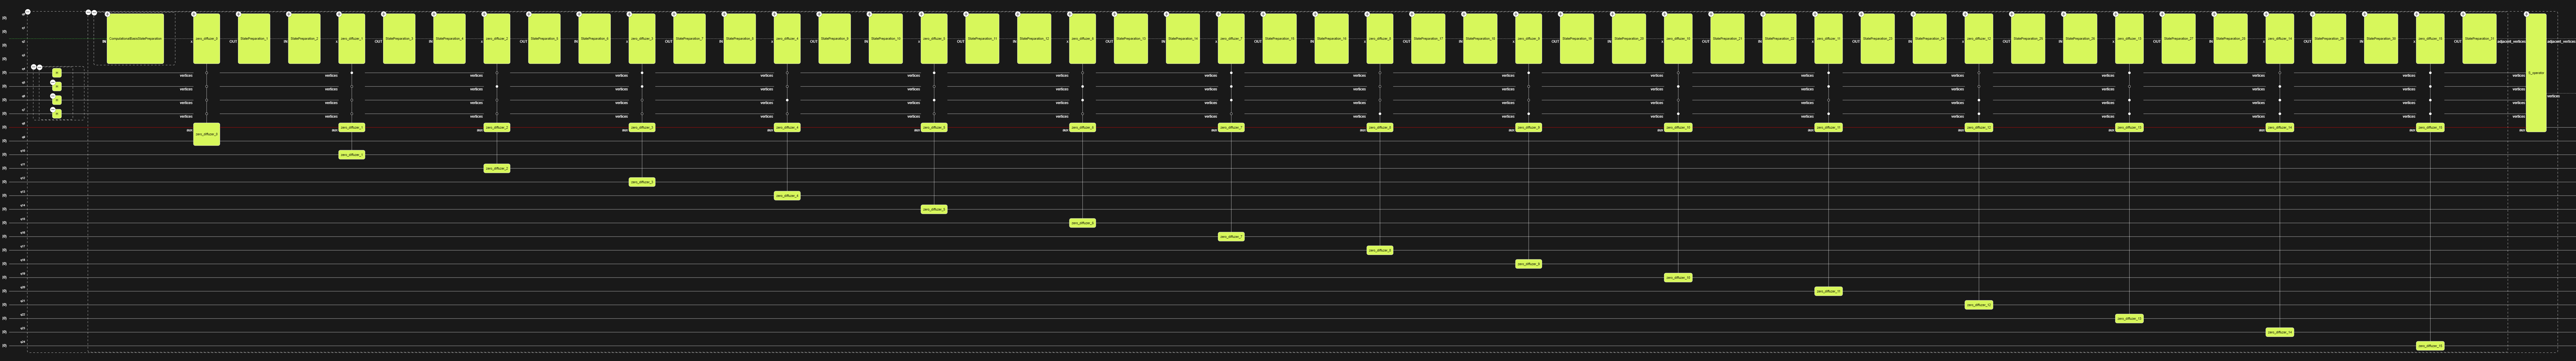


Finally the S operator contains an arithmetic module for the edge check and the swap operator
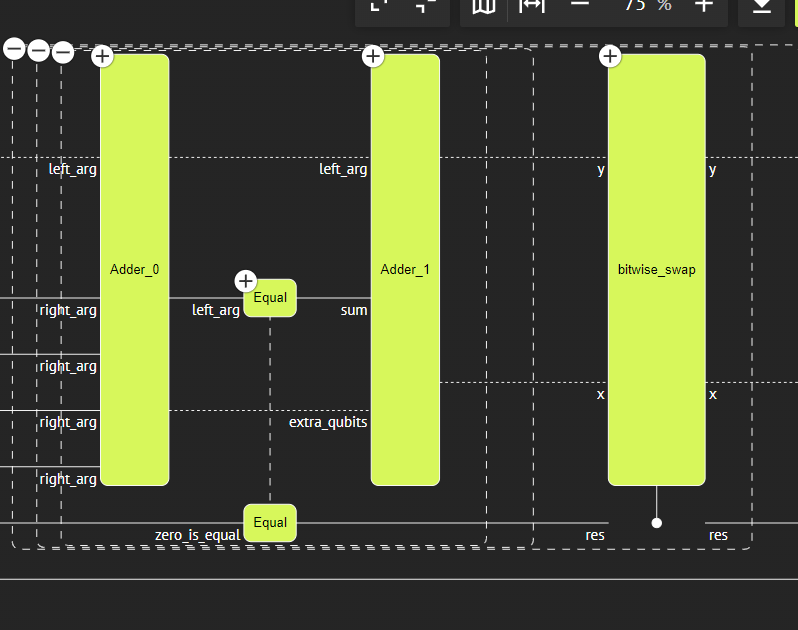

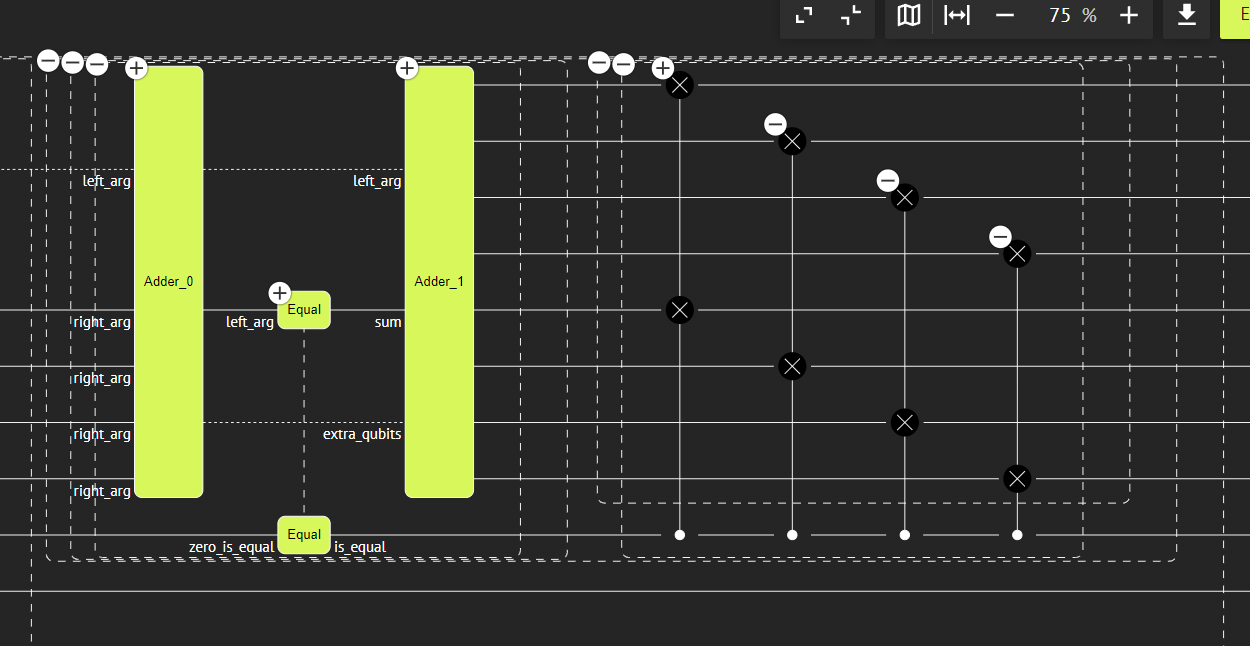

Let's run on 16000 shots on Classiq platform.  Our final histogram should approximate the uniform distribution
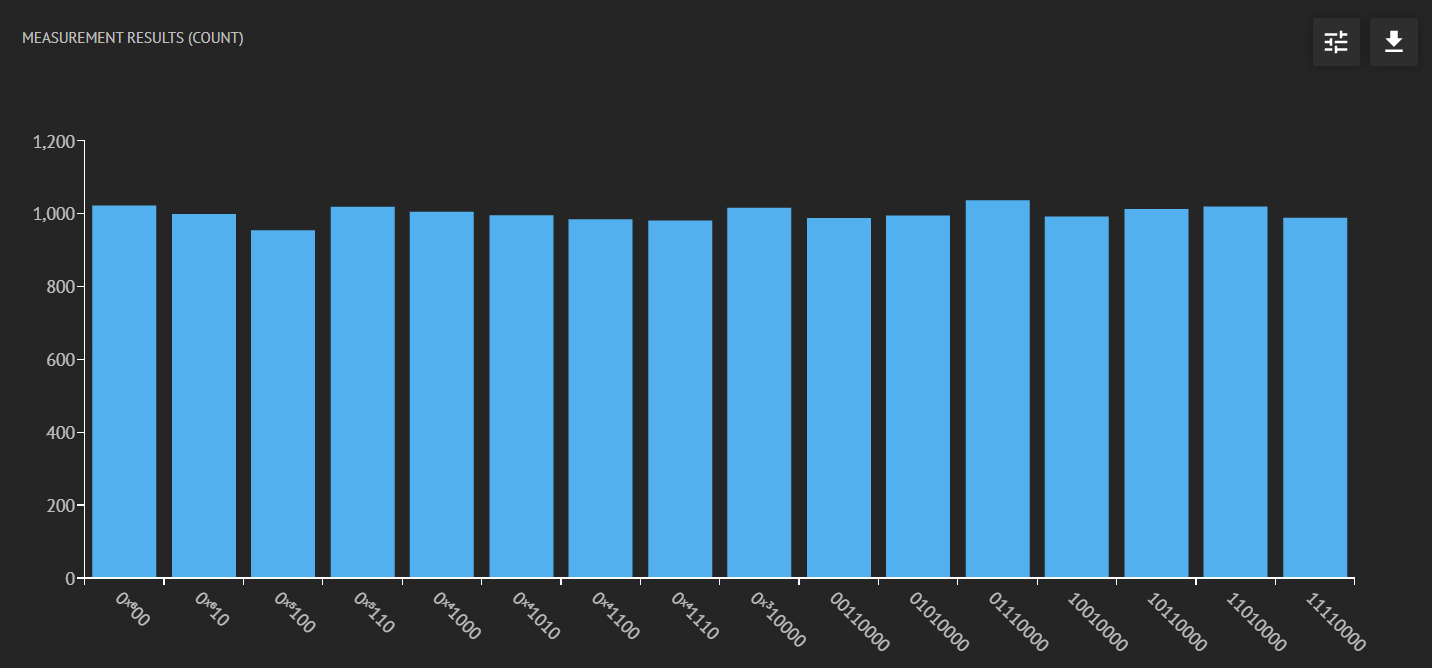

Remark that if we run the same circuit for 1000 shots, the approximation of the uniform distribution is worse
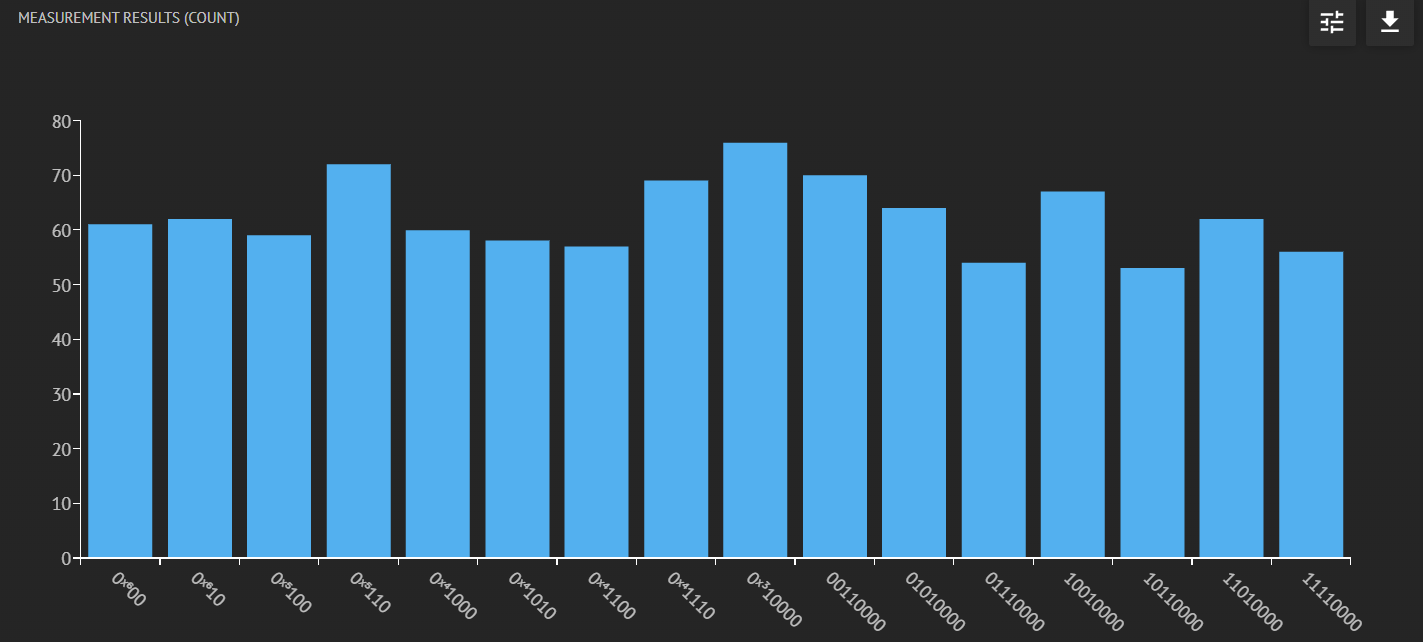

As we can see for 32000 shots, the approximation of the uniform distribution improves with the number of shots
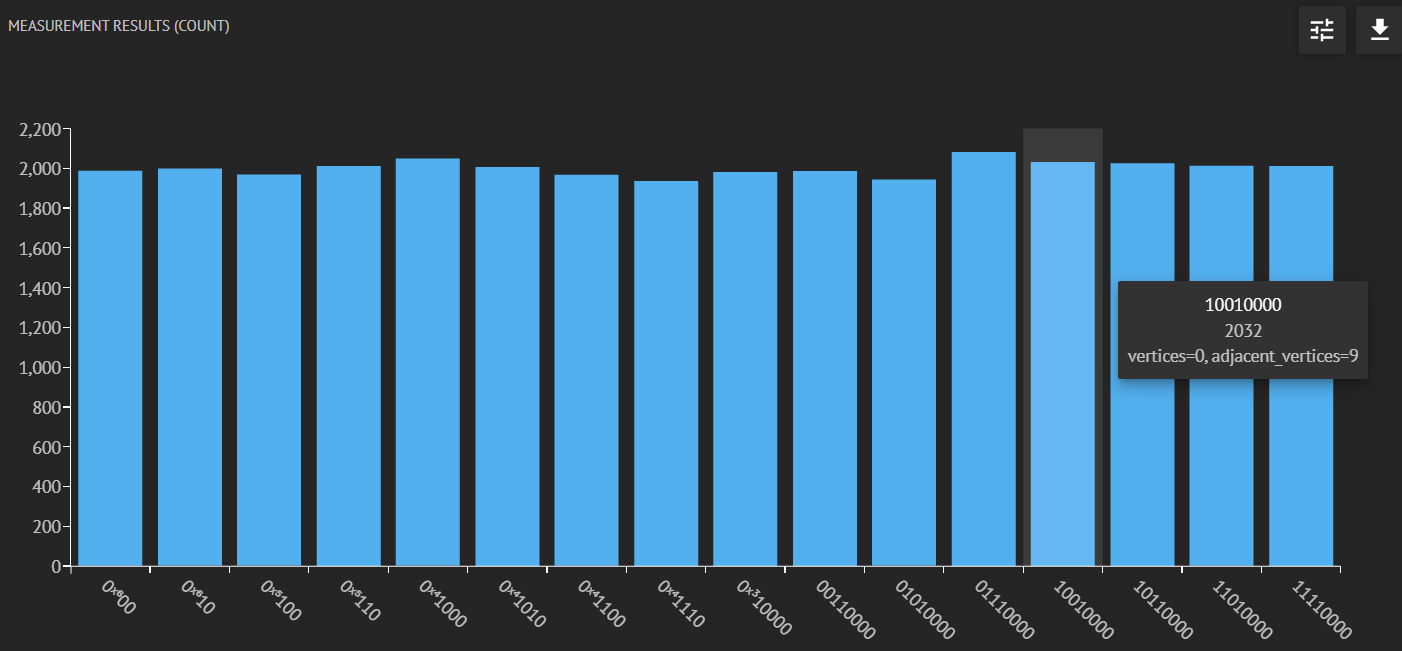